In [1]:
import os
import mne
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat
from mne.preprocessing import ICA
from mne.channels import make_standard_montage
from mne.io import RawArray

In [3]:
# New frequency for downsampling
new_sfreq = 200

# Parameters for band-pass filter
low_freq= 0
high_freq= 40
transition_bw = 2
filter_type = 'fir'
window = 'blackman'

# Parameters for epoching
tmin = 0
tmax = 0.85

In [4]:
folder_name = 'Dataset Motor Imagery'
cur_wdir = os.getcwd()
data_dir = os.path.join(cur_wdir, folder_name)
file_list = os.listdir(data_dir)
file_list

['5F-SubjectA-160405-5St-SGLHand.mat',
 '5F-SubjectA-160408-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-151110-5St-SGLHand.mat',
 '5F-SubjectB-160309-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160311-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160316-5St-SGLHand.mat',
 '5F-SubjectC-151204-5St-SGLHand.mat',
 '5F-SubjectC-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160321-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160415-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectF-151027-5St-SGLHand.mat',
 '5F-SubjectF-160209-5St-SGLHand.mat',
 '5F-SubjectF-160210-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160413-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160428-5St-SGLHand-HFREQ.mat',
 '5F-SubjectH-160804-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160719-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160723-5St-SGLHand-HFREQ.mat']

In [5]:
# Isolate files with 'HFREQ' in the name
hfreq_list = [filename for filename in file_list if 'HFREQ' in filename]
hfreq_list

['5F-SubjectA-160408-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160309-5St-SGLHand-HFREQ.mat',
 '5F-SubjectB-160311-5St-SGLHand-HFREQ.mat',
 '5F-SubjectC-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160321-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160415-5St-SGLHand-HFREQ.mat',
 '5F-SubjectE-160429-5St-SGLHand-HFREQ.mat',
 '5F-SubjectF-160210-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160413-5St-SGLHand-HFREQ.mat',
 '5F-SubjectG-160428-5St-SGLHand-HFREQ.mat',
 '5F-SubjectH-160804-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160719-5St-SGLHand-HFREQ.mat',
 '5F-SubjectI-160723-5St-SGLHand-HFREQ.mat']

In [6]:
df = pd.DataFrame()
for file in hfreq_list:
    loaded_file = loadmat(os.path.join(data_dir, file))
    df = df.append(loaded_file, ignore_index = True)
df

__globals__                                         __header__ __version__  \
0           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
1           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
2           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
3           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
4           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
5           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
6           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
7           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
8           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
9           []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
10          []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   
11          []  b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Crea...         1.0   
12          []  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...         1.0   

                                                    o  
0   [[[['201604081208.D091BB44'], ['NK-data import...  
1   [[[['201603091929.D091BB44'], ['NK-data import...  
2   [[[['201603111905.D091BB44'], ['NK-data import...  
3   [[[['201604291514.D091BB44'], ['NK-data import...  
4   [[[['201603211551.D091BB44'], ['NK-data import...  
5   [[[['201604151935.D091BB44'], ['NK-data import...  
6   [[[['201604291708.D091BB44'], ['NK-data import...  
7   [[[['201602101337.D091BB44'], ['NK-data import...  
8   [[[['201604131931.D091BB44'], ['NK-data import...  
9   [[[['201604281925.D091BB44'], ['NK-data import...  
10  [[[['201608041634.D091BB44'], ['NK-data import...  
11  [[[['201607191915.D091BB44'], ['NK-data import...  
12  [[[['201607231444.D091BB44'], ['NK-data import...

In [7]:
# Get EEG data from file
eeg_datas = df["o"]

In [8]:
channels = [eeg_datas[0]['chnames'][0][0][i][0][0] for i in range(len(eeg_datas[0]['chnames'][0][0]))]
ch_types = ['eeg'] * 21 + ['misc']
sfreq = eeg_datas[0]['sampFreq'][0, 0][0, 0]

In [9]:
# Create a list of the data in mne object
dataset = []
for index in list(eeg_datas.index):
    info_eeg = mne.create_info(ch_names = channels, sfreq = sfreq, ch_types = ch_types)
    data = eeg_datas[index]['data'][0][0].T
    eeg_data = RawArray(data, info_eeg)
    dataset.append(eeg_data)

Creating RawArray with float64 data, n_channels=22, n_times=3595000
    Range : 0 ... 3594999 =      0.000 ...  3594.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3582000
    Range : 0 ... 3581999 =      0.000 ...  3581.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3596000
    Range : 0 ... 3595999 =      0.000 ...  3595.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3582000
    Range : 0 ... 3581999 =      0.000 ...  3581.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3585000
    Range : 0 ... 3584999 =      0.000 ...  3584.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3587000
    Range : 0 ... 3586999 =      0.000 ...  3586.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3671000
    Range : 0 ... 3670999 =      0.000 ...  3670.999 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=3590000
 

In [10]:
# Create montage
for index in list(eeg_datas.index):
    montage = make_standard_montage('standard_1020')
    dataset[index].set_montage(montage)

In [11]:
# Add marker to the dataset list
for index in list(eeg_datas.index):
    marker_data = eeg_datas[index]['marker'][0][0].T
    info_marker = mne.create_info(['STI'], dataset[index].info['sfreq'], ['stim'])
    markers = RawArray(marker_data, info_marker)
    dataset[index].add_channels([markers], force_update_info = True)

Creating RawArray with float64 data, n_channels=1, n_times=3595000
    Range : 0 ... 3594999 =      0.000 ...  3594.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3582000
    Range : 0 ... 3581999 =      0.000 ...  3581.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3596000
    Range : 0 ... 3595999 =      0.000 ...  3595.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3582000
    Range : 0 ... 3581999 =      0.000 ...  3581.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3585000
    Range : 0 ... 3584999 =      0.000 ...  3584.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3587000
    Range : 0 ... 3586999 =      0.000 ...  3586.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3671000
    Range : 0 ... 3670999 =      0.000 ...  3670.999 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=3590000
    Range

In [12]:
events = []
for index in list(eeg_datas.index):
    event = mne.find_events(dataset[index], stim_channel = 'STI')
    events.append(event)

946 events found
Event IDs: [ 1  2  3  4  5 90 91 99]
941 events found
Event IDs: [ 1  2  3  4  5 92 99]
967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
947 events found
Event IDs: [ 1  2  3  4  5 91 99]
964 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
952 events found
Event IDs: [ 1  2  3  4  5 91 99]
953 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
959 events found
Event IDs: [1 2 3 4 5]
954 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
963 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
927 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
966 events found
Event IDs: [ 1  2  3  4  5 91 92 99]


In [13]:
# Record events in a dictionary
event_dict = {'thumb': 1, 'index': 2, 'middle': 3, 'ring': 4, 'pinky':5}

## STEP 2: DATASET VISUALIZATION

Creating RawArray with float64 data, n_channels=21, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


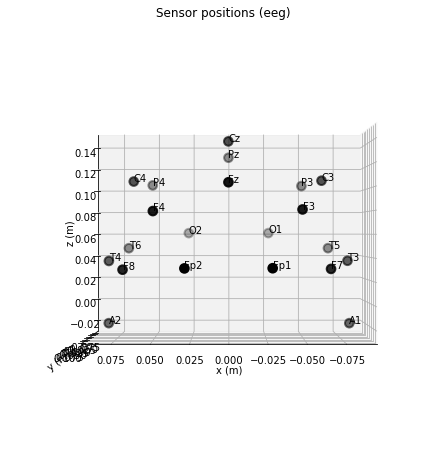

Creating RawArray with float64 data, n_channels=21, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


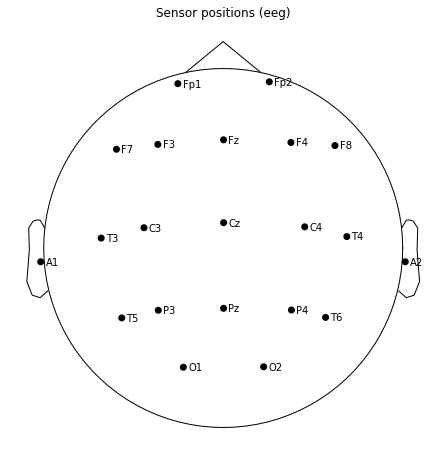

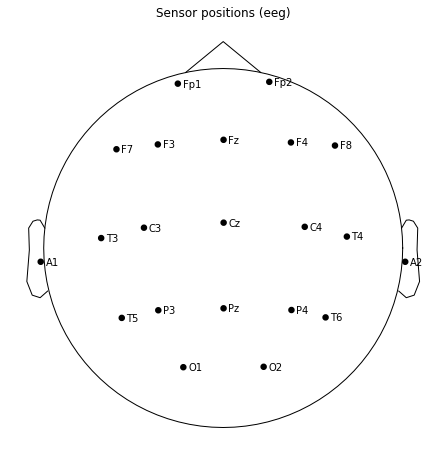

In [14]:
# Check dataset montage configuration plot
montage_check = dataset[0].get_montage()

fig = montage_check.plot(kind = '3d')
fig.gca().view_init(azim = 70, elev = 15)
montage_check.plot(kind = 'topomap', show_names = True)

In [1]:
# Plot the raw EEG data
for index in list(eeg_datas.index):
    mne.viz.plot_raw(dataset[index], events = events[index], start = 2, n_channels = 21, title = hfreq_list[index],
                     event_color = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 99: 'k'}, scalings = 'auto')

NameError: name 'eeg_datas' is not defined

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 90 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


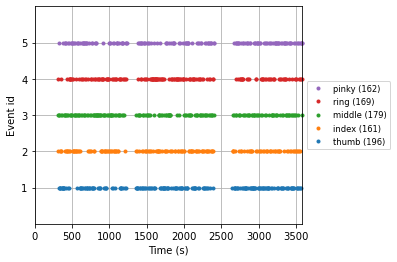

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


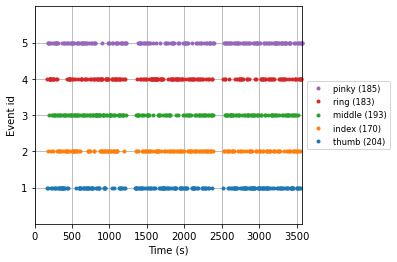

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


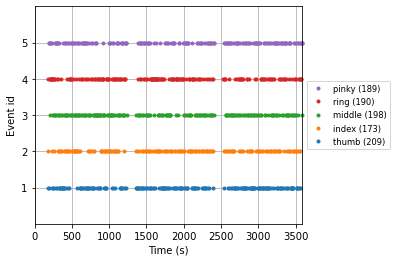

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


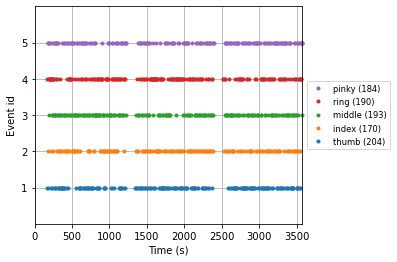

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


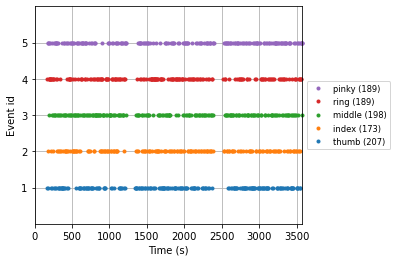

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


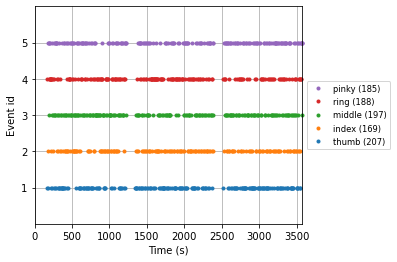

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


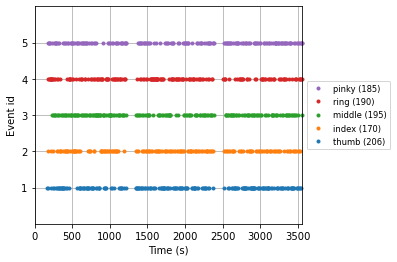

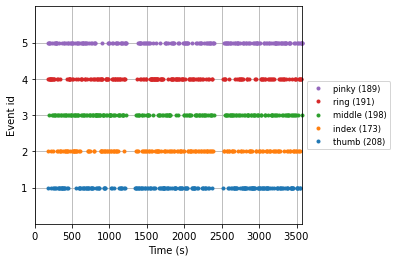

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


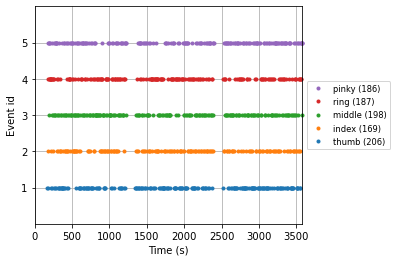

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


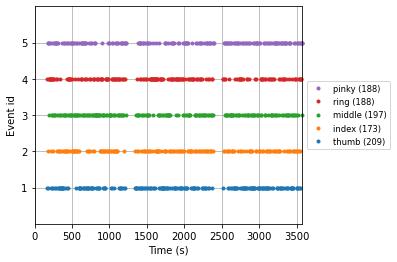

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


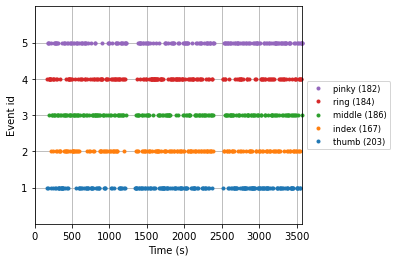

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


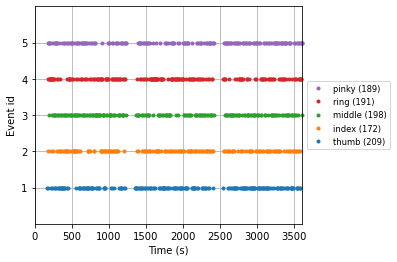

<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 91 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 92 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)
<ipython-input-16-8a99ba30060c>:3: RuntimeWarning: event 99 missing from event_id will be ignored
  fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)


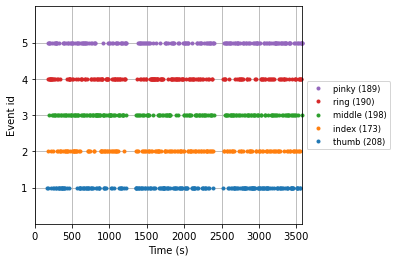

In [16]:
# Plotting event marker to check marker quantity 
for index in list(eeg_datas.index):
    fig = mne.viz.plot_events(events[index], sfreq = dataset[index].info['sfreq'], event_id = event_dict)

Effective window size : 2.048 (s)


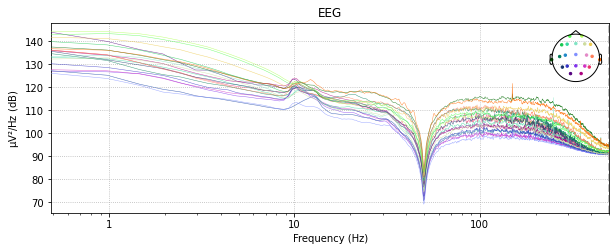

Effective window size : 2.048 (s)


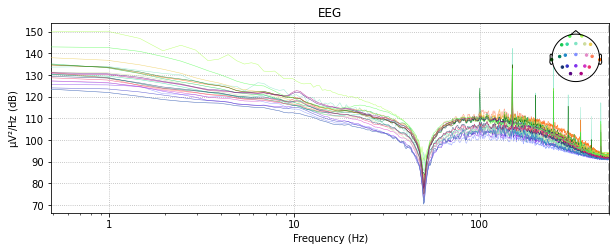

Effective window size : 2.048 (s)


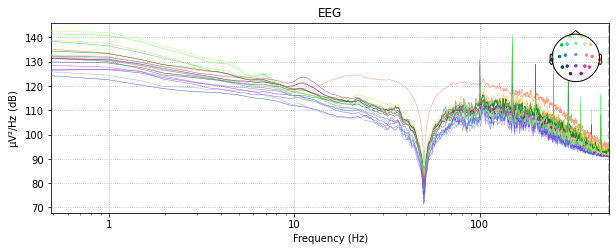

Effective window size : 2.048 (s)


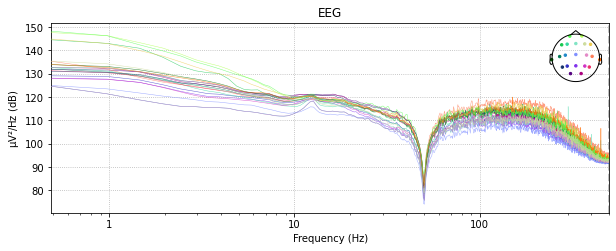

Effective window size : 2.048 (s)


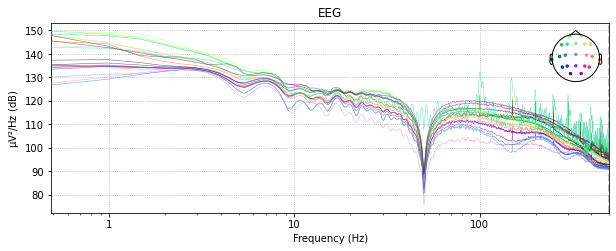

Effective window size : 2.048 (s)


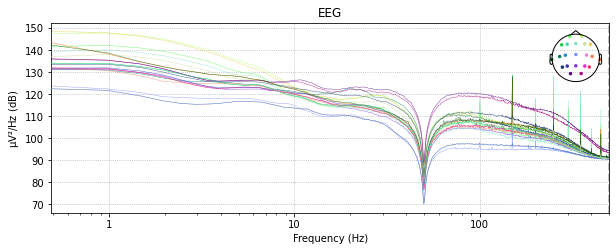

Effective window size : 2.048 (s)


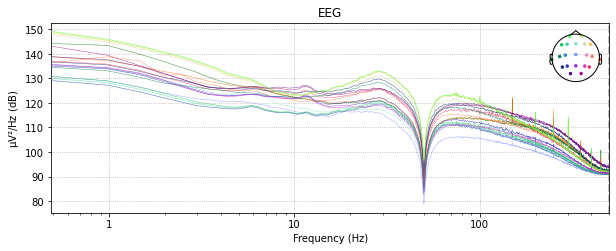

Effective window size : 2.048 (s)


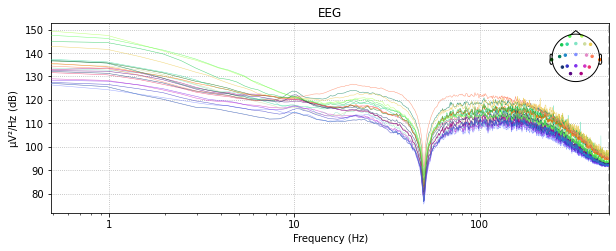

Effective window size : 2.048 (s)


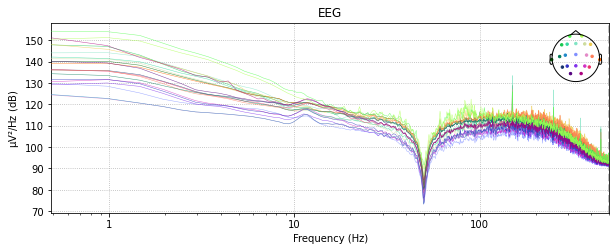

Effective window size : 2.048 (s)


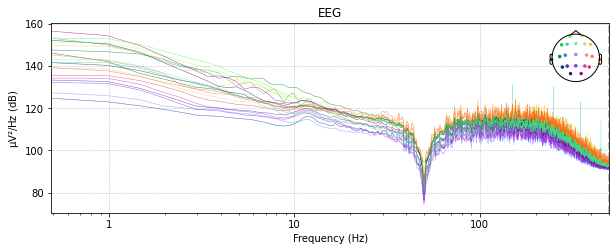

Effective window size : 2.048 (s)


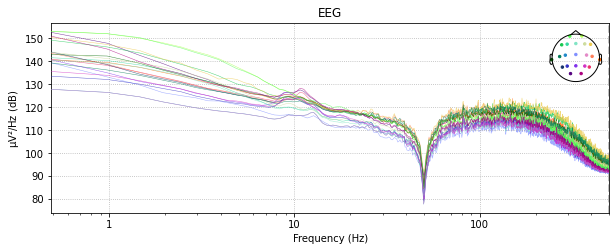

Effective window size : 2.048 (s)


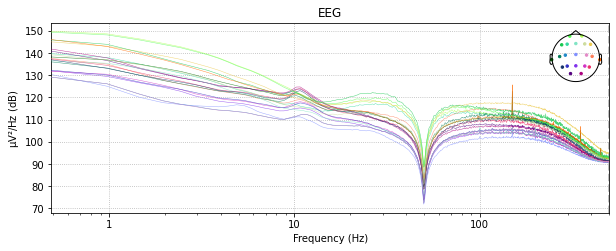

Effective window size : 2.048 (s)


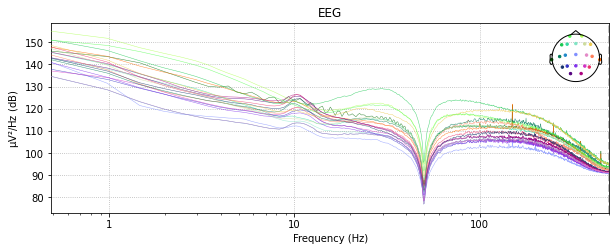

In [17]:
# Power Spectral Density
for index in list(eeg_datas.index):
    mne.viz.plot_raw_psd(dataset[index], fmax = np.inf, reject_by_annotation = False, xscale = 'log')

Effective window size : 2.048 (s)


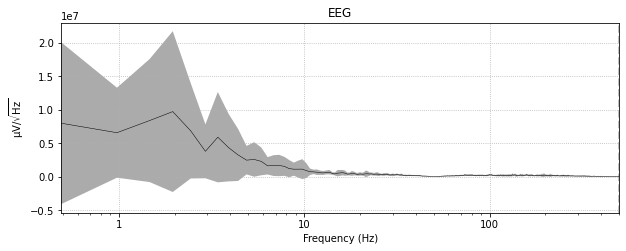

Effective window size : 2.048 (s)


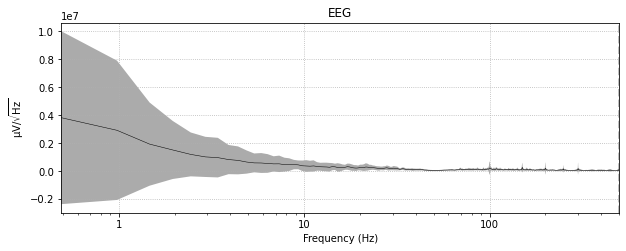

Effective window size : 2.048 (s)


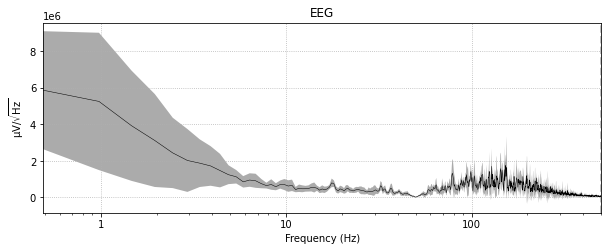

Effective window size : 2.048 (s)


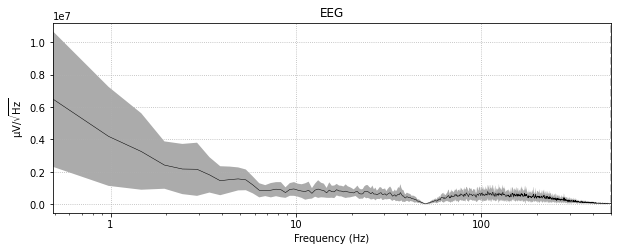

Effective window size : 2.048 (s)


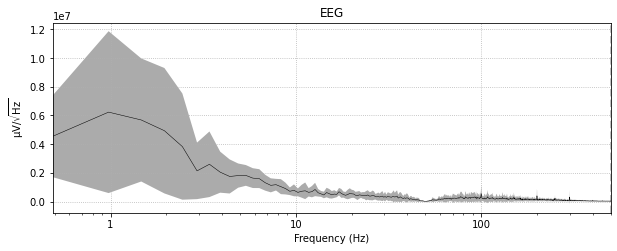

Effective window size : 2.048 (s)


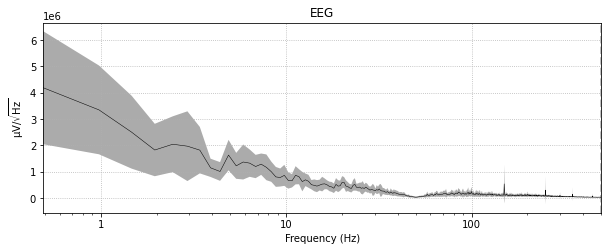

Effective window size : 2.048 (s)


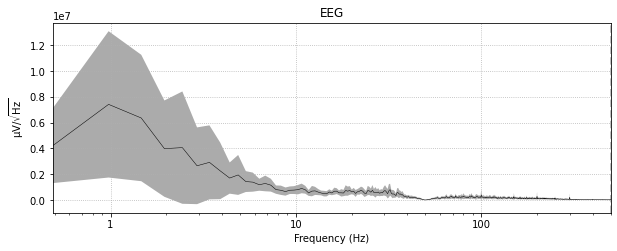

Effective window size : 2.048 (s)


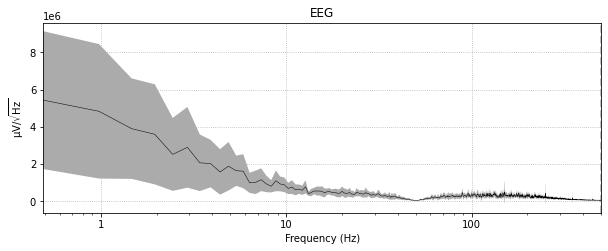

Effective window size : 2.048 (s)


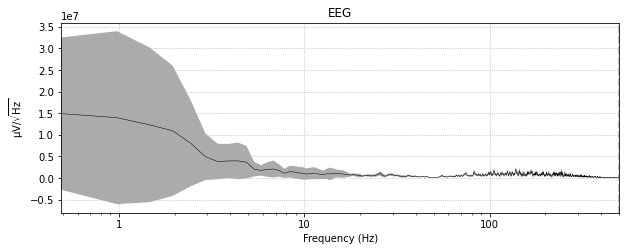

Effective window size : 2.048 (s)


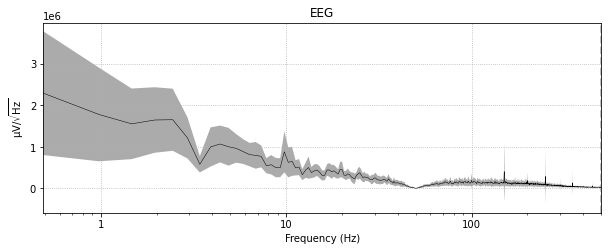

Effective window size : 2.048 (s)


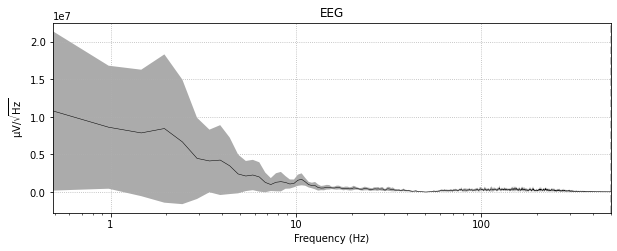

Effective window size : 2.048 (s)


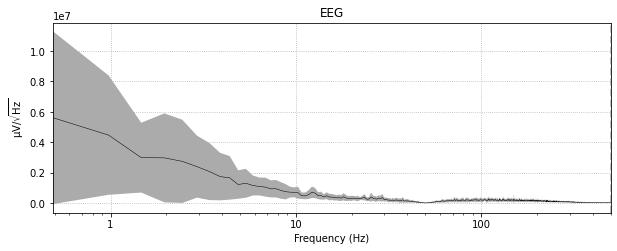

Effective window size : 2.048 (s)


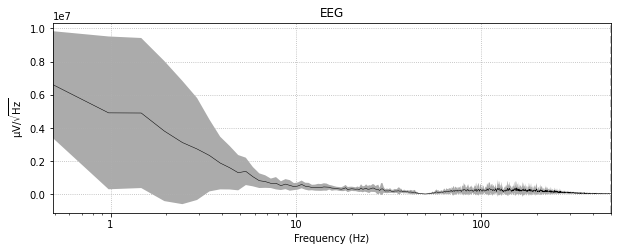

In [18]:
# Amplitude Spectral Density
for index in list(eeg_datas.index):
    dataset[index].plot_psd(tmax=10., average = True, spatial_colors = True, dB = False, xscale = 'log')

## STEP 3: PREPROCESSING AND SIGNAL QUALITY ANALYSIS

Preprocessing step:
1. Rereferencing signal at average of A1 and A2 (because number of channels <32)
    Source: Li Hu
2. Bandpass filter at 10-40 Hz (alpha: 10-12, beta: 14=18, gamma: 36-40) source:Pfurtscheller1999
3. epoching (bad epoch rejection)
4. Artifact rejection using ICA




##Filtering

In [14]:
# Low-pass filtering
filter_params = mne.filter.create_filter(dataset[0].get_data(), dataset[0].info['sfreq'], l_freq = low_freq,
                                         h_freq = high_freq, method = filter_type, fir_window = window,
                                         h_trans_bandwidth = transition_bw)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 2501 samples (2.501 sec)



In [24]:
for index in range(len(hfreq_list)):
    print(hfreq_list[index])
    print(epochs[index])

5F-SubjectA-160408-5St-SGLHand-HFREQ.mat
<Epochs |  867 events (all good), 0 - 0.845 sec, baseline off, ~23.6 MB, data loaded,
 'index': 161
 'middle': 179
 'pinky': 162
 'ring': 169
 'thumb': 196>
5F-SubjectB-160309-5St-SGLHand-HFREQ.mat
<Epochs |  935 events (all good), 0 - 0.845 sec, baseline off, ~25.5 MB, data loaded,
 'index': 170
 'middle': 193
 'pinky': 185
 'ring': 183
 'thumb': 204>
5F-SubjectB-160311-5St-SGLHand-HFREQ.mat
<Epochs |  959 events (all good), 0 - 0.845 sec, baseline off, ~26.2 MB, data loaded,
 'index': 173
 'middle': 198
 'pinky': 189
 'ring': 190
 'thumb': 209>
5F-SubjectC-160429-5St-SGLHand-HFREQ.mat
<Epochs |  941 events (all good), 0 - 0.845 sec, baseline off, ~25.7 MB, data loaded,
 'index': 170
 'middle': 193
 'pinky': 184
 'ring': 190
 'thumb': 204>
5F-SubjectE-160321-5St-SGLHand-HFREQ.mat
<Epochs |  956 events (all good), 0 - 0.845 sec, baseline off, ~26.1 MB, data loaded,
 'index': 173
 'middle': 198
 'pinky': 189
 'ring': 189
 'thumb': 207>
5F-Subject

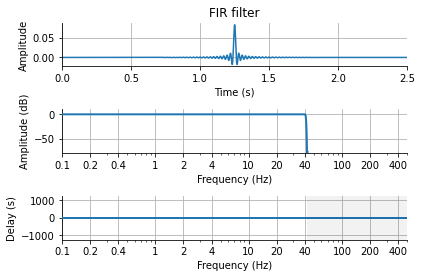

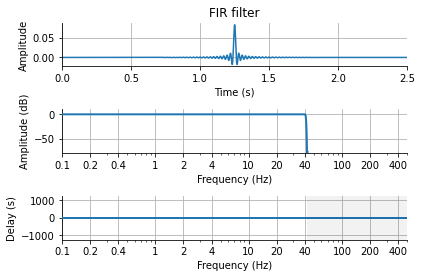

In [15]:
mne.viz.plot_filter(filter_params, dataset[0].info['sfreq'])

In [16]:
# Filtering the signal
for index in list(eeg_datas.index):
    dataset[index].filter(l_freq = low_freq, h_freq = high_freq, picks = None, filter_length = 'auto',
                          l_trans_bandwidth = 'auto', h_trans_bandwidth = transition_bw, 
                          method = filter_type, fir_window = window)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 2501 samples (2.501 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 2501 samples (2.501 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filt

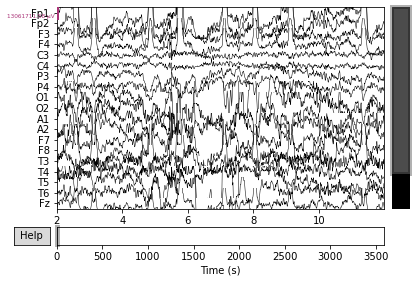

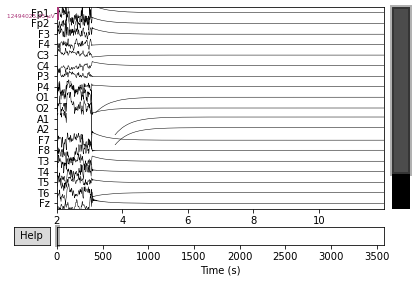

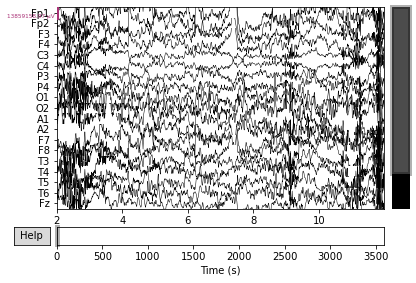

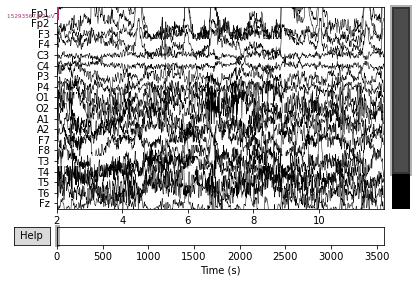

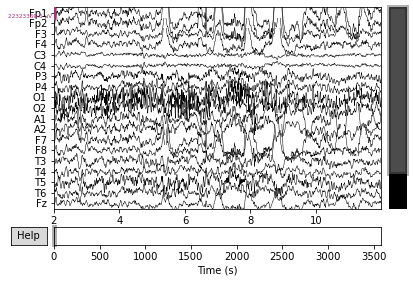

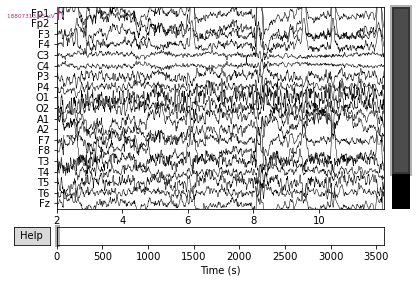

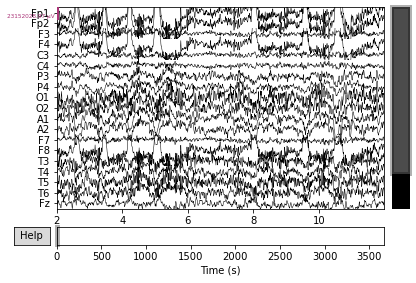

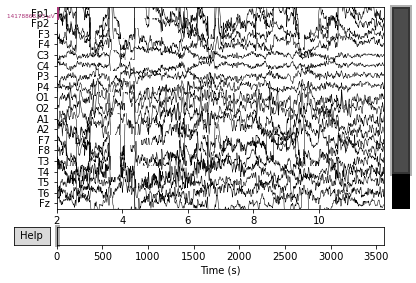

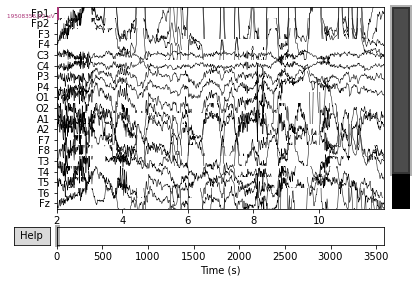

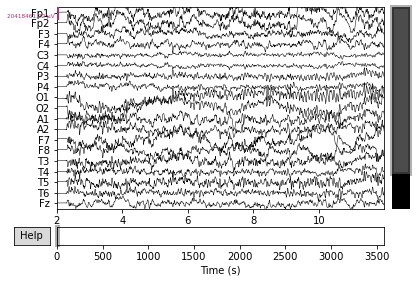

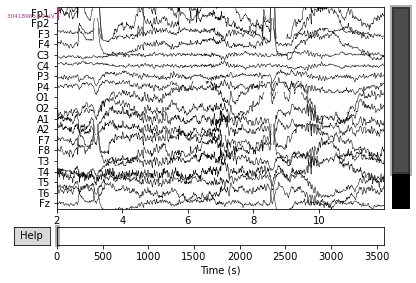

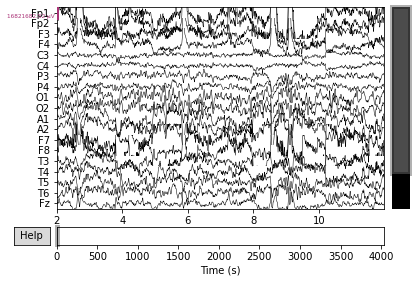

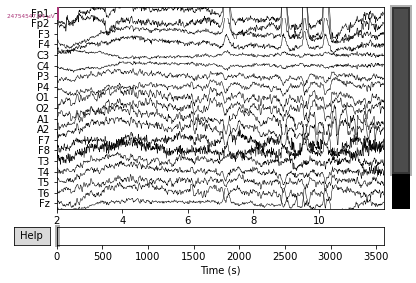

In [22]:
for index in list(eeg_datas.index):
    mne.viz.plot_raw(dataset[index], events = events[index], start = 2, n_channels = 19, title = hfreq_list[index],
                     event_color = {1: 'r', 2: 'g', 3: 'b', 4: 'm', 5: 'y', 99: 'k'}, scalings = 'auto')

Effective window size : 2.048 (s)


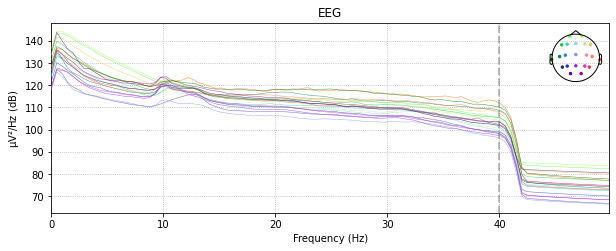

Effective window size : 2.048 (s)


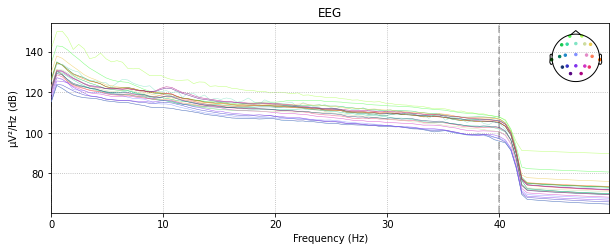

Effective window size : 2.048 (s)


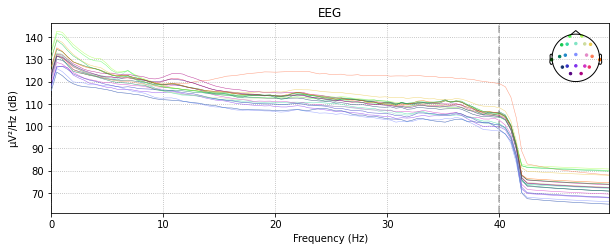

Effective window size : 2.048 (s)


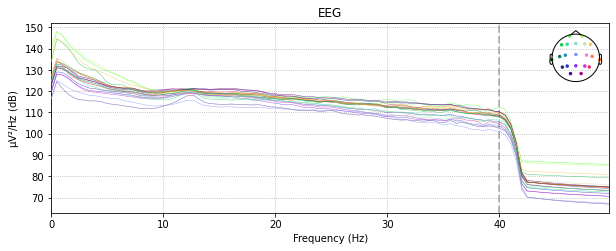

Effective window size : 2.048 (s)


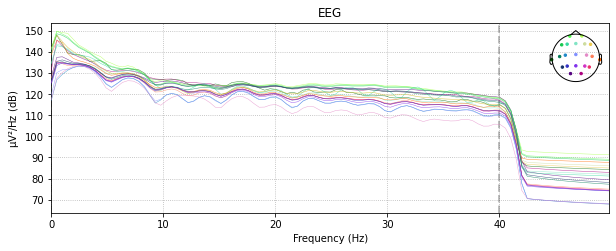

Effective window size : 2.048 (s)


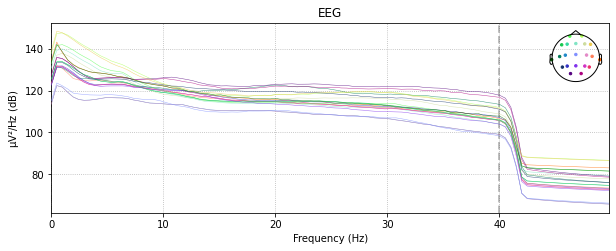

Effective window size : 2.048 (s)


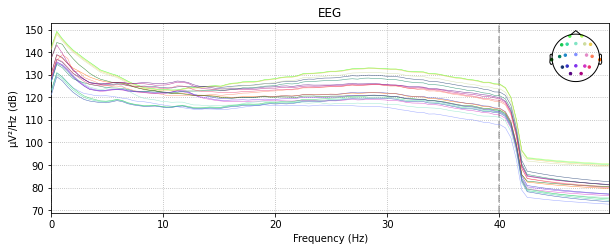

Effective window size : 2.048 (s)


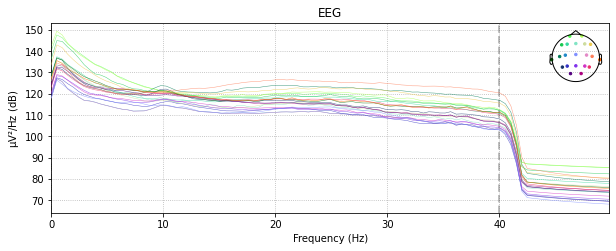

Effective window size : 2.048 (s)


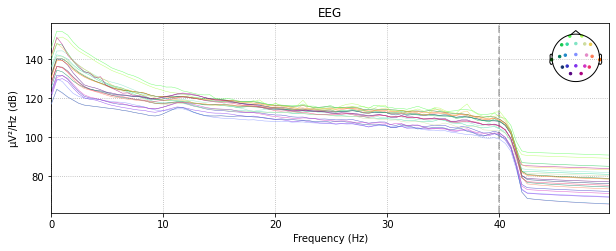

Effective window size : 2.048 (s)


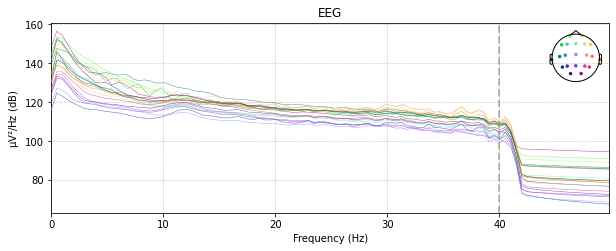

Effective window size : 2.048 (s)


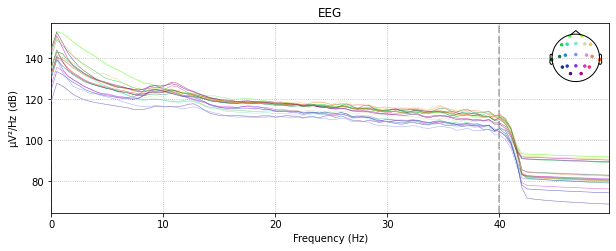

Effective window size : 2.048 (s)


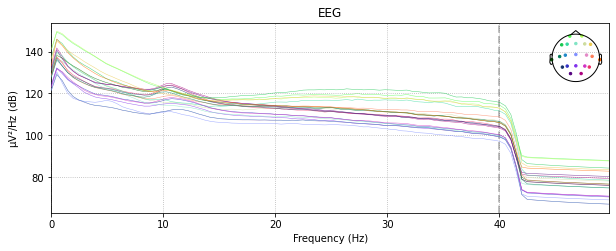

Effective window size : 2.048 (s)


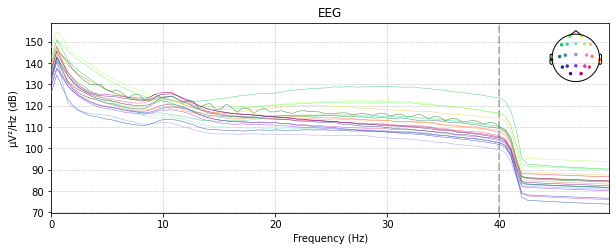

In [22]:
#plot psd of filtered signal
for index in list(eeg_datas.index):
    mne.viz.plot_raw_psd(dataset[index], fmax = 50, reject_by_annotation = False, xscale = 'linear')

Effective window size : 2.048 (s)


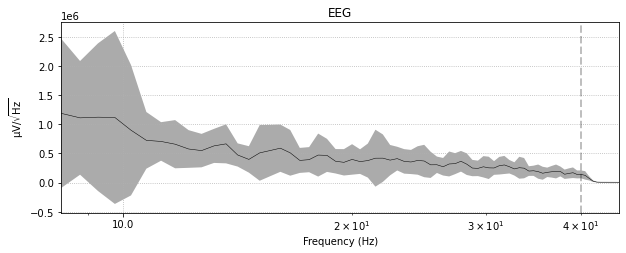

Effective window size : 2.048 (s)


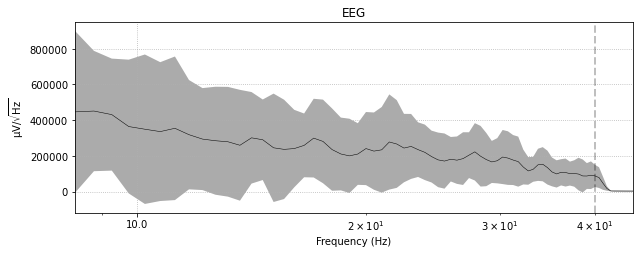

Effective window size : 2.048 (s)


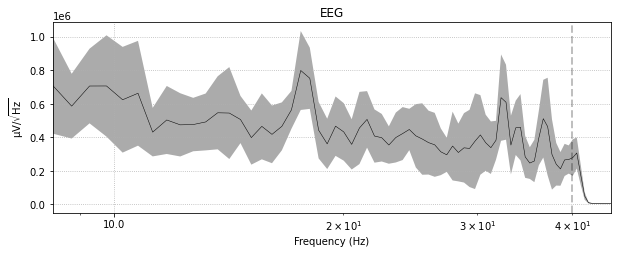

Effective window size : 2.048 (s)


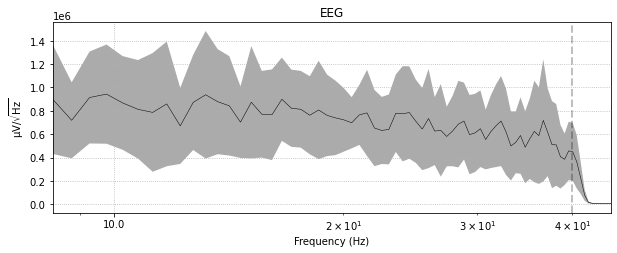

Effective window size : 2.048 (s)


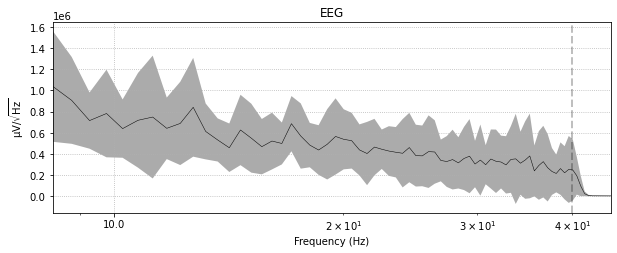

Effective window size : 2.048 (s)


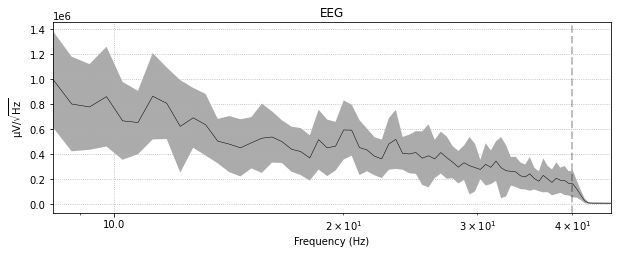

Effective window size : 2.048 (s)


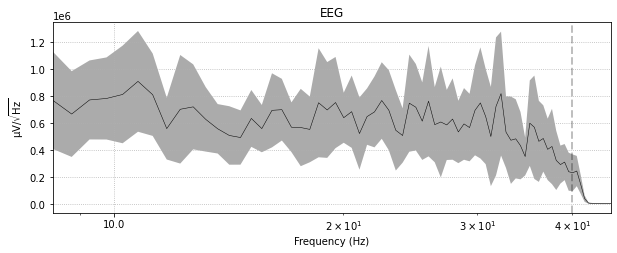

Effective window size : 2.048 (s)


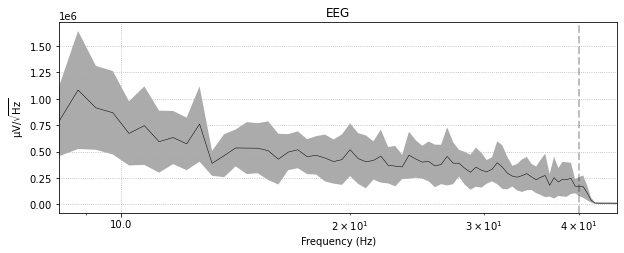

Effective window size : 2.048 (s)


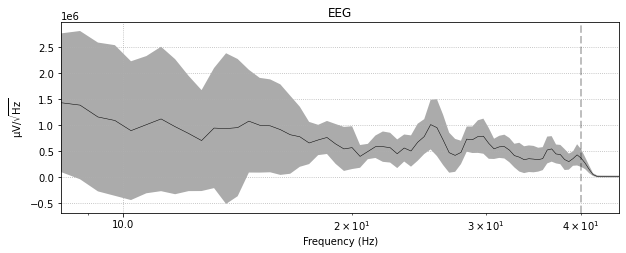

Effective window size : 2.048 (s)


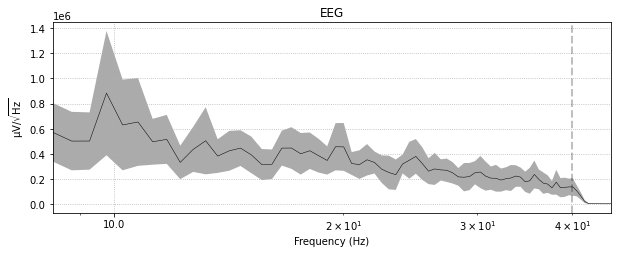

Effective window size : 2.048 (s)


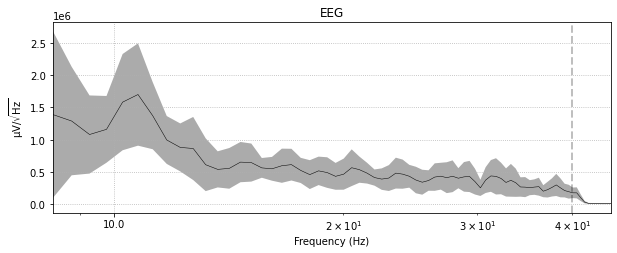

Effective window size : 2.048 (s)


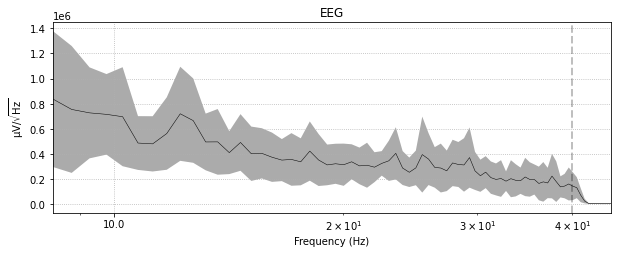

Effective window size : 2.048 (s)


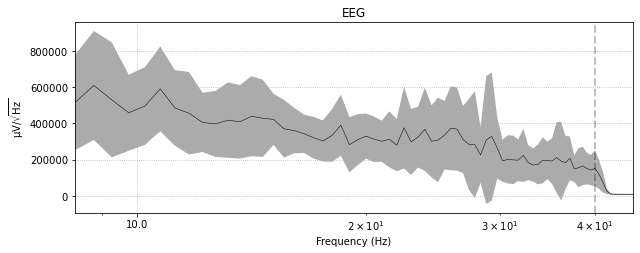

In [23]:
#signal PSD Variance
for index in list(eeg_datas.index):
    dataset[index].plot_psd(tmax = 10., fmin = 8, fmax = 45, average = True, spatial_colors = True,
                            dB = False, xscale = 'log')

Rentang frekuensi yang diambil adalah 10-40Hz, rentang tersebut mengandung alpha ERD, beta ERS, dan gamma oscilation selama dan setelah MI jari tangan

## Epoching & Down-sampling

In [17]:
# Epoching raw EEG
epochs = []
for index in list(eeg_datas.index):
    dataset[index].drop_channels(['X5', 'STI'])
    _epoch = mne.Epochs(dataset[index], events = events[index], tmin = tmin, tmax = tmax,
                        event_id = event_dict, preload = True, baseline = None)
    # Resampling only for signals with sampling frequency of 1000 Hz
    _epoch.resample(new_sfreq)
    epochs.append(_epoch)

Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Loading data for 867 events and 851 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
935 matching events found
No baseline correction applied
0 projection items activated
Loading data for 935 events and 851 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 851 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
941 matching events found
No baseline correction applied
0 projection items activated
Loading data for 941 events and 851 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
956 matching events found
No baseline correction applied
0 projection items activated
Loading data for 956 events and 

epoch yang diambil dari t= -2 sekon hingga t=0.75s sesuai dengan rentang waktu terjadinya ERS/ERD.  Tapi di Kaya dkk, dari 0-0.85

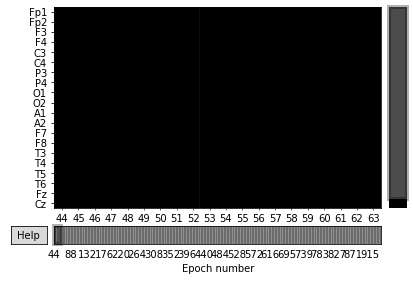

Figure(432x288)


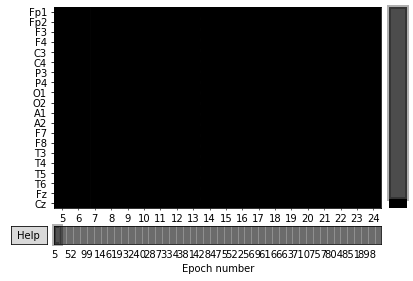

Figure(432x288)


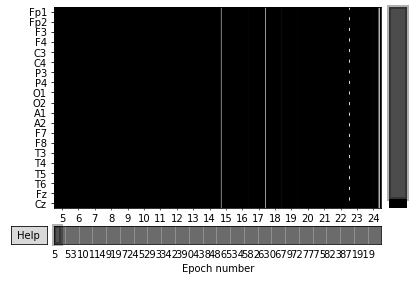

Figure(432x288)


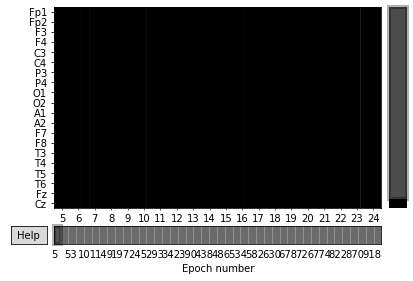

Figure(432x288)


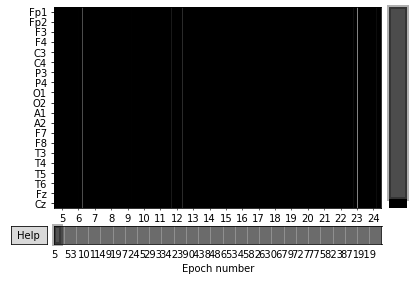

Figure(432x288)


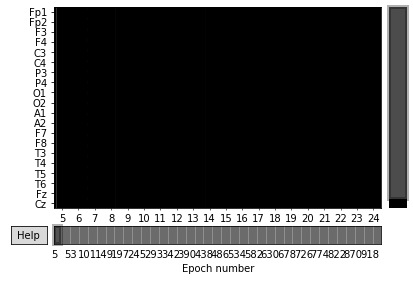

Figure(432x288)


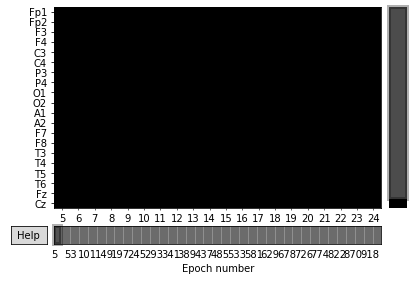

Figure(432x288)


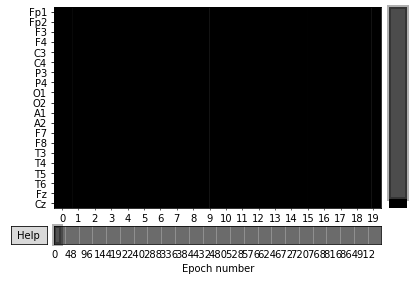

Figure(432x288)


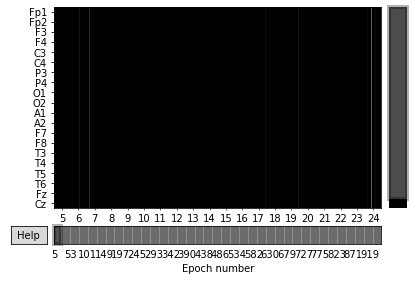

Figure(432x288)


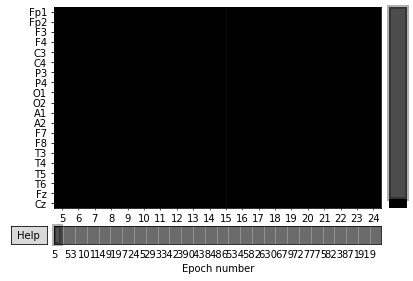

Figure(432x288)


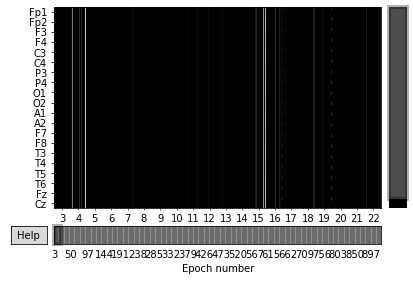

Figure(432x288)


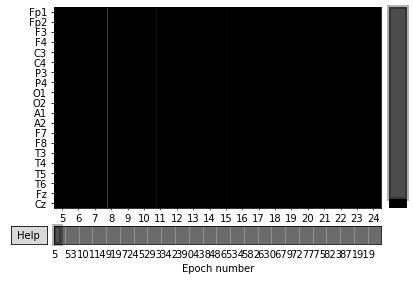

Figure(432x288)


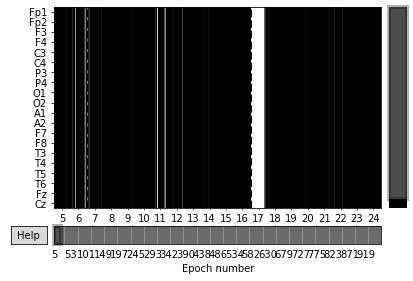

Figure(432x288)


In [25]:
for index in list(eeg_datas.index):
    print(epochs[index].plot(picks = epochs[index].ch_names))

Not setting metadata
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


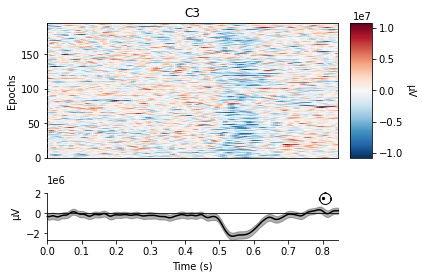

Not setting metadata
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


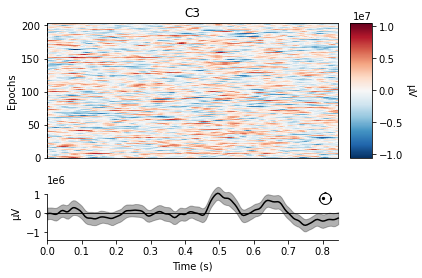

Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


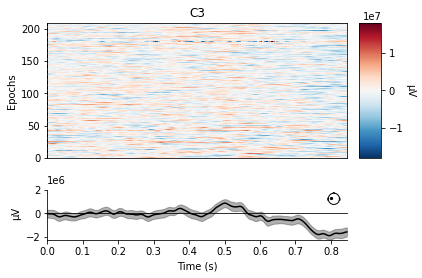

Not setting metadata
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


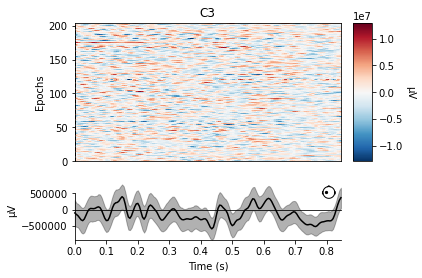

Not setting metadata
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


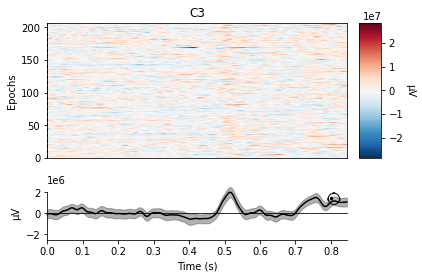

Not setting metadata
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


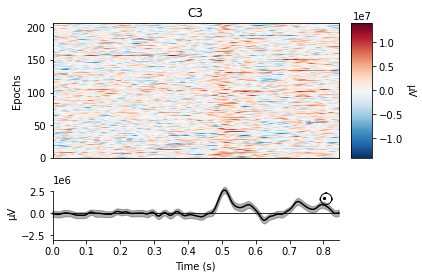

Not setting metadata
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


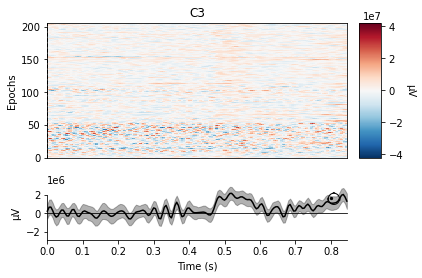

Not setting metadata
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


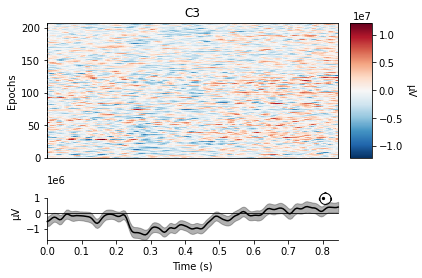

Not setting metadata
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


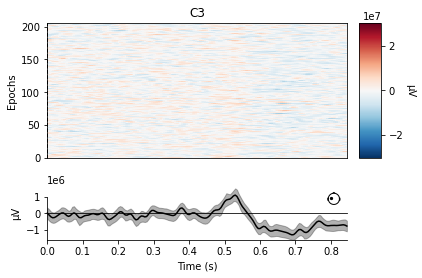

Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


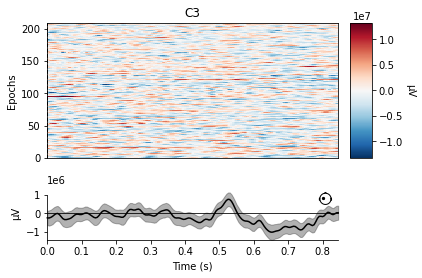

Not setting metadata
Not setting metadata
203 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


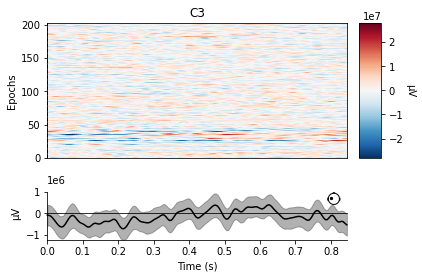

Not setting metadata
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


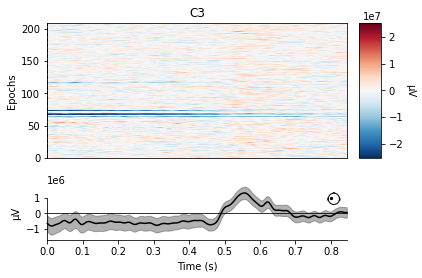

Not setting metadata
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


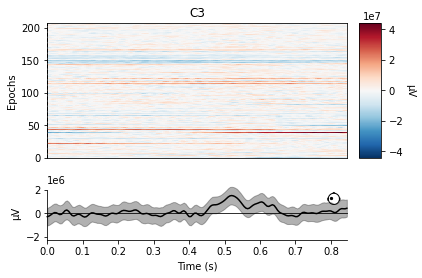

In [26]:
# Plot the average epoch on C3
for index in list(eeg_datas.index): 
    epochs[index]['thumb'].plot_image(picks = 'C3')

No projector specified for this dataset. Please consider the method self.add_proj.


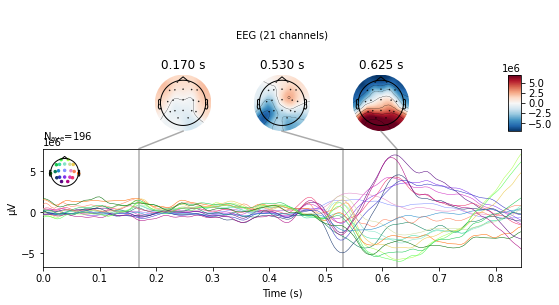

No projector specified for this dataset. Please consider the method self.add_proj.


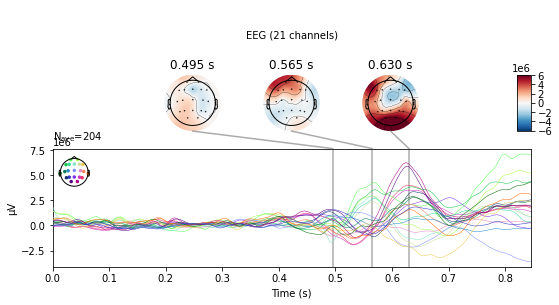

No projector specified for this dataset. Please consider the method self.add_proj.


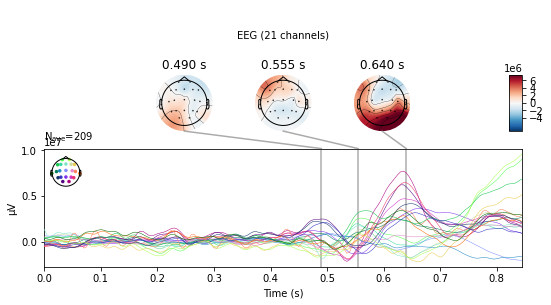

No projector specified for this dataset. Please consider the method self.add_proj.


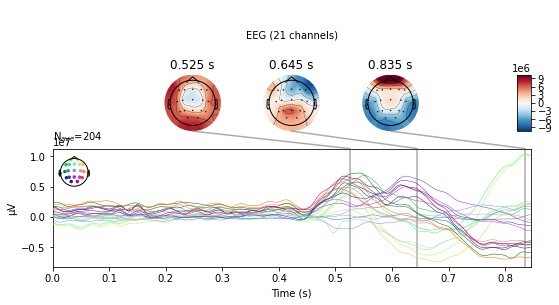

No projector specified for this dataset. Please consider the method self.add_proj.


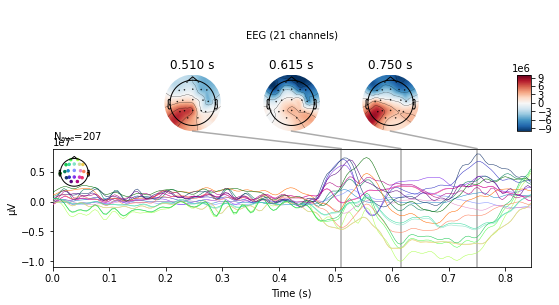

No projector specified for this dataset. Please consider the method self.add_proj.


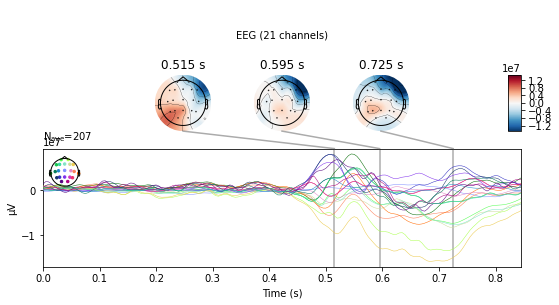

No projector specified for this dataset. Please consider the method self.add_proj.


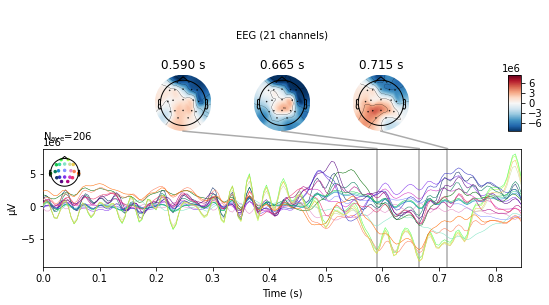

No projector specified for this dataset. Please consider the method self.add_proj.


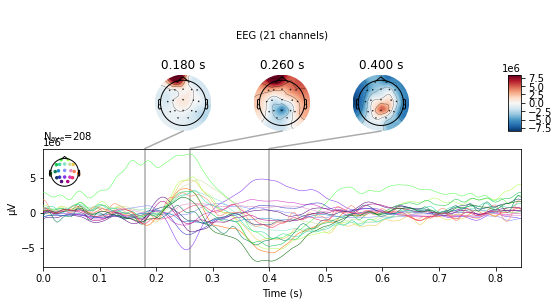

No projector specified for this dataset. Please consider the method self.add_proj.


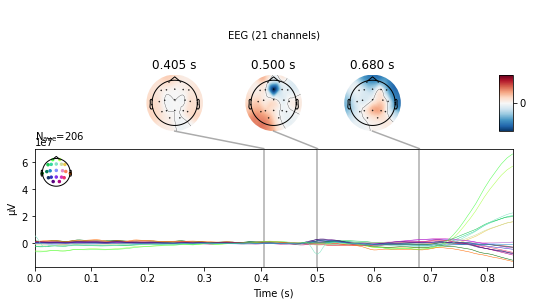

No projector specified for this dataset. Please consider the method self.add_proj.


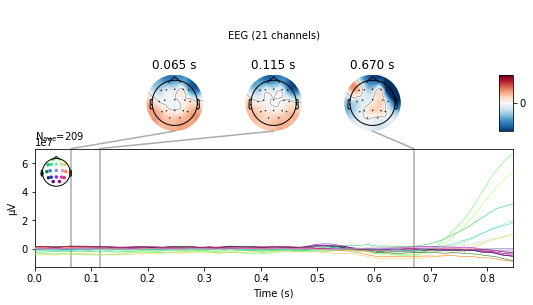

No projector specified for this dataset. Please consider the method self.add_proj.


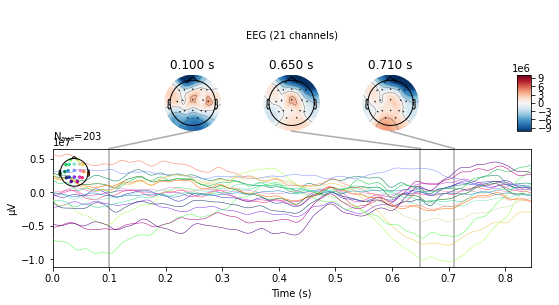

No projector specified for this dataset. Please consider the method self.add_proj.


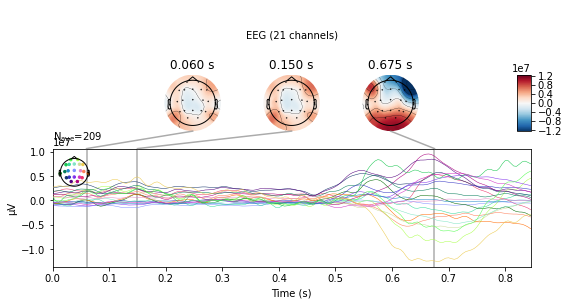

No projector specified for this dataset. Please consider the method self.add_proj.


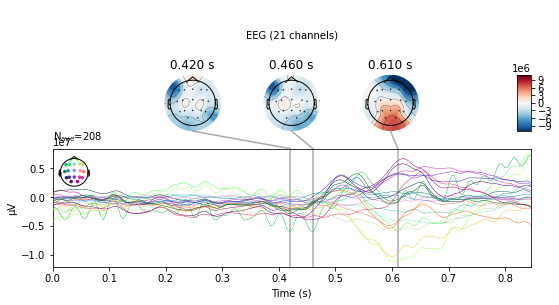

In [27]:
evoked_eeg =[]
for index in list(eeg_datas.index): 
    evoked = epochs[index]['thumb'].average()
    evoked.plot_joint()
    evoked_eeg.append(evoked)

In [28]:
save_folder = 'Preprocessed Data MI'
epoch_folder = 'Epoch'
save_epoch_path = os.path.join(cur_wdir, save_folder, epoch_folder)
if not os.path.isdir(save_epoch_path):
    os.mkdir(save_epoch_path)

In [29]:
event_folder = 'Event'
save_event_path = os.path.join(cur_wdir, save_folder, event_folder)
if not os.path.isdir(save_event_path):
    os.mkdir(save_event_path)

In [30]:
for index, filename in enumerate(hfreq_list):
    parsed_name = filename.split('-')
    new_filename = parsed_name[1] + '-' + parsed_name[2] + '-eve.fif'
    mne.write_events(os.path.join(save_event_path, new_filename), events[index])

In [31]:
for index, filename in enumerate(hfreq_list):
    parsed_name = filename.split('-')
    new_filename = parsed_name[1] + '-' + parsed_name[2] + '-epo.fif'
    epochs[index].save(os.path.join(save_epoch_path, new_filename), overwrite = True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [32]:
# # In case you want to remove files
# check_name = 'eve.fif' # Change this variable if you want to remove files
# for fif_file in os.listdir(save_event_path):
#     if check_name in fif_file:
#         os.remove(os.path.join(save_epoch_path, fif_file))